In [1]:
! pip install langgraph langsmith 

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 12.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
! pip install langchain langchain_groq langchain_community

In [12]:
import os 
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv("GROQ_API_KEY")
langsmith_api_key=os.getenv("LANGSMITH_API_KEY")

In [13]:
os.environ["LANGCHAIN_TRACING_V2"]='true'
os.environ['LANGSMITH_API_KEY']=langsmith_api_key
os.environ["LANGCHAIN_PROJECT"]="Lang-app"


In [14]:
from langchain_groq import ChatGroq
llm=ChatGroq(api_key=groq_api_key,model="gemma2-9b-it")

In [15]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000016D436467B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000016D436A4440>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

## TOOLS

In [2]:
! pip install arxiv wikipedia

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11756 sha256=49f3f2a9a83eabc938f0ccc6984a6a39935980259da7e1e1601c8c4e95510f9d
  Stored in directory: c:\users\abhin\appdata\local\pip\cache\wheels\79\1d\c8\b64e19423cc5a2a339450ea5d145


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
arxiv_tool=ArxivQueryRun(api_wrapper=  arxiv_wrapper) 

wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper)


In [17]:
wiki_tool.invoke("Who is founder of APPLE")

"Page: Apple Inc.\nSummary: Apple Inc. is an American multinational corporation and technology company headquartered in Cupertino, California, in Silicon Valley. It is best known for its consumer electronics, software, and services. Founded in 1976 as Apple Computer Company by Steve Jobs, Steve Wozniak and Ronald Wayne, the company was incorporated by Jobs and Wozniak as Apple Computer, Inc. the following year. It was renamed Apple Inc. in 2007 as the company had expanded its focus from computers to consumer electronics. Apple is the largest technology company by revenue, with US$391.04 billion in the 2024 fiscal year.\nThe company was founded to produce and market Wozniak's Apple I personal computer. Its second computer, the Apple II, became a best seller as one of the first mass-produced microcomputers. Apple introduced the Lisa in 1983 and the Macintosh in 1984, as some of the first computers to use a graphical user interface and a mouse. By 1985, internal company problems led to Jo

In [18]:
arxiv_tool.invoke("RESNET")

'Published: 2016-03-25\nTitle: Resnet in Resnet: Generalizing Residual Architectures\nAuthors: Sasha Targ, Diogo Almeida, Kevin Lyman\nSummary: Residual networks (ResNets) have recently achieved state-of-the-art on\nchallenging computer vision tasks. We introduce Resnet in Resnet (RiR): a deep\ndual-stream architecture that generalizes ResNets and standard CNNs and is\neasily implemented with no computational overhead. RiR consistently improves\nperformance over ResNets, outperforms architectures with similar amounts of\naugmentation on CIFAR-10, and establishes a new state-of-the-art on CIFAR-100.'

In [35]:
tools=[wiki_tool,]

# Start Building Chatbot using Langraph

- Building the multi-agent chat bot with the help of the Langchain and Langgraph which can then be later used in the pipeline of another RAG based application or a different app

In [36]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

- Messages have the Type list, The add messages function will be responsible for adding the messages to this list rather than replacing them

In [37]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [38]:
graph_builder

In [39]:
llm_with_tools=llm.bind_tools(tools=tools)

In [40]:
def chatbot(state:State):
    return {"messages":llm_with_tools.invoke(state['messages'])}

In [41]:
graph_builder.add_node('Chatbot',chatbot)
graph_builder

- Adding tool node and the tool Condition

In [42]:
from langgraph.prebuilt import ToolNode,tools_condition
tool_node=ToolNode(tools=tools)

- Connecting the Chatbot to the start and the end node

In [43]:
graph_builder.add_edge(START,'Chatbot')
graph_builder.add_node('tools',tool_node)
graph_builder.add_conditional_edges("Chatbot",tools_condition)
graph_builder.add_edge('tools','Chatbot')
graph_builder.add_edge('Chatbot',END) 


In [44]:
graph=graph_builder.compile()

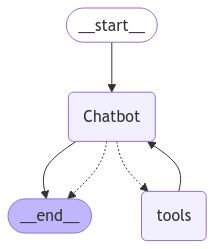

In [45]:
from IPython.display import Image , display
try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [32]:
while True:
    user_input=input("User: ")
    if user_input.lower() in ['quit','q','exit']:
        print("Good Bye")
        break
    for event in graph.stream({'messages':("user",user_input)},stream_mode='values'):
        # print(event.values())
        # for value in event.values():
        #     print(value['messages'])
        #     print("Assistant: ",value['messages'].content)
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi I am Abihnav from Kaithal
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_s1fa)
 Call ID: call_s1fa
  Args:
    query: Abhinav
================================= Tool Message =================================
Name: wikipedia

Page: Abhinav
Summary: Abhinava (Devanagari: अभिनव) is an Indian given name. The Sanskrit word abhinava has the meaning "new". Abhinava also means innovative, young, modern, fresh.


================================== Ai Message ==================================

That's interesting!  Do you know what your name means in Hindi?
================================ Human Message =================================

tell me abou the my force 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_aprh)
 Call ID: call_aprh
  Args:
    query: my force
========================

In [47]:
query='Hi there , My name is Abhinav'
events=graph.stream({'messages':("user",query)},stream_mode='values')

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there , My name is Abhinav
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_g1cn)
 Call ID: call_g1cn
  Args:
    query: Abhinav
================================= Tool Message =================================
Name: wikipedia

Page: Abhinav
Summary: Abhinava (Devanagari: अभिनव) is an Indian given name. The Sanskrit word abhinava has the meaning "new". Abhinava also means innovative, young, modern, fresh.


================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_848v)
 Call ID: call_848v
  Args:
    query: Abhinav (name)
================================= Tool Message =================================
Name: wikipedia

Page: Abhinav Kashyap
Summary: Abhinav Singh Kashyap (born 6 September 1974) is an Indian film director and screenwriter, who gained recognition for directing and co-writing 